__Because there are so many images that doesn't contain any kind of fraud I decided to first train a model that determines whether picture has a fraud or not__

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import layers
from keras.applications import resnet, mobilenet
import glob
from keras.models import Sequential
import cv2
%run readandsubmit.ipynb
import warnings
warnings.filterwarnings("ignore")
# import keras

Using TensorFlow backend.


In [0]:
frauds = readConfigs()
names = readImgNames()

In [0]:
df = pd.DataFrame(names,columns=["ImageId"])
df["hasFraud"] = np.array([1 if i in frauds["ImageId"].unique() else 0 for i in names ]).astype(str)

In [0]:
df.head()

,ImageId,hasFraud
0,dea277f4a.jpg,1
1,b845ef149.jpg,1
2,ba1500f6f.jpg,0
3,9172281a1.jpg,0
4,10378f8ea.jpg,1


So we'll train out model on that dataset and I'll write a datagen for every image of it.

In [0]:
def createGen():
    return ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        zca_whitening=True,
        fill_mode='reflect',
        rotation_range=10,
        height_shift_range=0.1,
        width_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.2
    )

In [0]:
def createTrainValFlow(generator, type_):
    return generator.flow_from_dataframe(
        df,
        directory="resized",
        x_col="ImageId",
        y_col="hasFraud",
        class_mode='binary',
        target_size=(256, 256),
        batch_size=32,
        subset=type_
    )

In [53]:
generator = createGen()
train = createTrainValFlow(generator, "training")
val = createTrainValFlow(generator, "validation")

Found 10055 validated image filenames belonging to 2 classes.
Found 2513 validated image filenames belonging to 2 classes.


In [0]:
def build_model():
    mobilenet_ = mobilenet.MobileNet(
        include_top=False,
        input_shape=(256,256,3),
        weights='imagenet',
    )
    
    model = Sequential()
    model.add(mobilenet_)
    model.add(layers.GlobalMaxPooling2D())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer="adam",
        metrics=['accuracy']
    )
    
    return model

In [0]:
model = build_model()

In [56]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 8, 8, 1024)        3228864   
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1024)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)              

In [59]:
total_steps = df.shape[0] / 32
checkpoint = ModelCheckpoint(
    'weights/model.h5', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1
)
es = EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=3
)
history = model.fit_generator(
    train,
    validation_data=val,
    steps_per_epoch=total_steps * 0.85,
    validation_steps=total_steps * 0.15,
    epochs=50,
    callbacks=[reduce_lr,es,checkpoint],
    verbose=1
)

Epoch 1/50
334/333 [==============================] - 209s 625ms/step - loss: 0.2118 - acc: 0.9153 - val_loss: 0.2054 - val_acc: 0.9184

Epoch 00001: val_acc improved from -inf to 0.91843, saving model to model.h5
Epoch 2/50
334/333 [==============================] - 202s 605ms/step - loss: 0.2092 - acc: 0.9176 - val_loss: 0.1743 - val_acc: 0.9290

Epoch 00002: val_acc improved from 0.91843 to 0.92899, saving model to model.h5
Epoch 3/50
334/333 [==============================] - 203s 608ms/step - loss: 0.1923 - acc: 0.9212 - val_loss: 0.2895 - val_acc: 0.8815

Epoch 00003: val_acc did not improve from 0.92899
Epoch 4/50
334/333 [==============================] - 203s 608ms/step - loss: 0.1927 - acc: 0.9244 - val_loss: 0.2840 - val_acc: 0.8824

Epoch 00004: val_acc did not improve from 0.92899
Epoch 5/50
334/333 [==============================] - 204s 610ms/step - loss: 0.2052 - acc: 0.9184 - val_loss: 0.3167 - val_acc: 0.8729

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0

So model gives me a validation score of 0.928 which is good enough for me, it could be improved with using bigger pretrained nn, but it would 
take more time to learn.

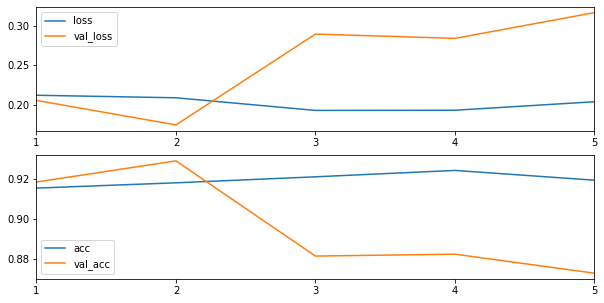

In [89]:
history_df = pd.DataFrame(history.history).rename(index={i:i+1 for i in range(5)})

_, ax = plt.subplots(nrows=2,figsize=(10,5))
ax[0].xaxis.set_ticks(range(1,6))
ax[1].xaxis.set_ticks(range(1,6))
history_df[['loss', 'val_loss']].plot(ax=ax[0]);
history_df[['acc', 'val_acc']].plot(ax=ax[1]);